# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:
1. can leverage an existing neural network architecture proven to work on problems similar to our own
2. can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

## Downloading and becoming one with the data


In [1]:
# Get Data (10% of 10 food classes from Food101)

import zipfile

#Download the data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip  

#unzip the downloaded file

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-18 03:59:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   185MB/s    in 0.9s    

2022-10-18 03:59:16 (185 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder

import os

#walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in  '{dirpath}.'")


There are 2 directories and 0 images in  '10_food_classes_10_percent.'
There are 10 directories and 0 images in  '10_food_classes_10_percent/test.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/ice_cream.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/sushi.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/ramen.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/chicken_curry.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/pizza.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/fried_rice.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/grilled_salmon.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/steak.'
There are 0 directories and 250 images in  '10_food_classes_10_percent/test/hamburger.'
There are 0 directories and 250 images in  '10_food_classes_10_per

## Creating data loaders (preparing the data)

We'll use the image data generator class to load in our images in batches


In [3]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir= "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(1/255.)
test_datagen = ImageDataGenerator(1/255.)


print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                    target_size=IMAGE_SHAPE,
                                    batch_size=BATCH_SIZE,
                                    class_mode="categorical")


Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callback
* Model checkpointing with the ModelCheckpoint callback
* Stopping a model from training before it trains too long and overfits with the EarlyStopping callback



In [4]:
# Create TensorBoard call back (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback


## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pre-trained models on: tfhub.dev

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [5]:
 # Let's compare the following two models
 resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
 efficient_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
 mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model function to create a model from a URL

def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub url and creates a keras sequential model with it. 
  Args:
    model_url (str) : A tensorflow hub feature extraction url.
    num_classes (int) : # of output neurons in output layer, 
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a keras layer 
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

### Creating ResNet Tensorflow Hub Feature Extraction model


In [32]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [33]:
# compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [34]:
# fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data_10_percent,
                 validation_steps = len(test_data_10_percent),
                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          experiment_name="resnet50V2")])


Saving TensorBoard log files to tensorflow_hub/resnet50V2/20221018-021028
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


24/24 [==============================] - 20s 693ms/step - loss: 130.1951 - accuracy: 0.0947 - val_loss: 63.5269 - val_accuracy: 0.1036
Epoch 2/5
24/24 [==============================] - 16s 667ms/step - loss: 56.5044 - accuracy: 0.1067 - val_loss: 61.7889 - val_accuracy: 0.1376
Epoch 3/5
24/24 [==============================] - 17s 719ms/step - loss: 46.7098 - accuracy: 0.1680 - val_loss: 42.0879 - val_accuracy: 0.1956
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 38.8238 - accuracy: 0.1920 - val_loss: 32.4613 - val_accuracy: 0.1940
Epoch 5/5
24/24 [==============================] - 15s 656ms/step - loss: 33.3691 - accuracy: 0.1867 - val_loss: 31.0469 - val_accuracy: 0.2064


In [8]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

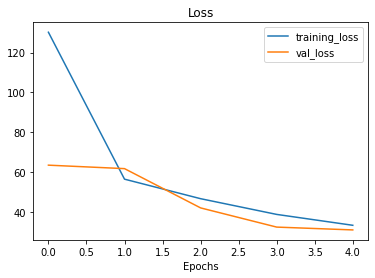

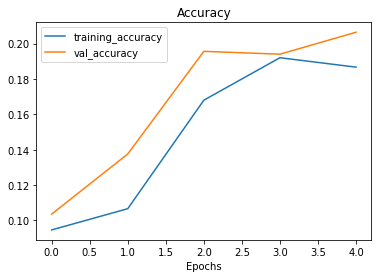

In [36]:
plot_loss_curves(resnet_history)

# Creating and testing EfficientNetB0 Hub Feature Extraction model

In [37]:
# create model
efficientnet_model = create_model(efficient_url,
                                  num_classes=train_data_10_percent.num_classes)


In [38]:
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])


In [39]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs = 10,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data_10_percent,
                       validation_steps = len(test_data_10_percent),
                       callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                experiment_name="EfficientNetB0")])


Saving TensorBoard log files to tensorflow_hub/EfficientNetB0/20221018-021154
Epoch 1/10
24/24 [==============================] - 19s 661ms/step - loss: 748.6735 - accuracy: 0.0840 - val_loss: 605.5913 - val_accuracy: 0.1056
Epoch 2/10
24/24 [==============================] - 15s 632ms/step - loss: 448.5921 - accuracy: 0.1493 - val_loss: 600.2441 - val_accuracy: 0.1088
Epoch 3/10
24/24 [==============================] - 15s 630ms/step - loss: 301.4256 - accuracy: 0.1933 - val_loss: 530.1035 - val_accuracy: 0.1044
Epoch 4/10
24/24 [==============================] - 15s 630ms/step - loss: 251.0683 - accuracy: 0.2253 - val_loss: 519.4327 - val_accuracy: 0.1068
Epoch 5/10
24/24 [==============================] - 15s 631ms/step - loss: 189.1322 - accuracy: 0.2627 - val_loss: 555.8471 - val_accuracy: 0.1120
Epoch 6/10
24/24 [==============================] - 15s 625ms/step - loss: 192.3380 - accuracy: 0.2627 - val_loss: 548.8922 - val_accuracy: 0.1128
Epoch 7/10
24/24 [======================

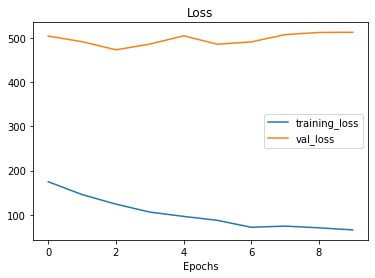

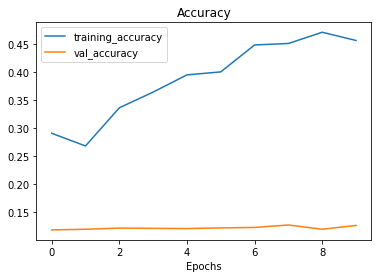

In [24]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is"** transfer learning using an existing model with no changes whatsoever (e.g. using imagenet model on 1000 image net classes, none of your own)
* **"Feature Extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food))
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


In [ ]:
# How many layers does our efficientnetb0 feature extractor have

efficientnet_model.layers[0].weights

## Comparing our model's results using TensorBoard

In [ ]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name "EfficientNetB0 vs. resnet50V2" \
 --description "Comparing 2 different TF Hu feature extraction model architectures using 10% of the training data" \
 --one_shot 

# Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/2IBWxJwrTAuwPqxB5yMggw/

In [45]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/2IBWxJwrTAuwPqxB5yMggw/
	Name                 EfficientNetB0 vs. resnet50V2
	Description          Comparing 2 different TF Hu feature extraction model architectures using 10% of the training data
	Id                   2IBWxJwrTAuwPqxB5yMggw
	Created              2022-10-18 02:33:28 (4 minutes ago)
	Updated              2022-10-18 02:33:39 (4 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              240
	Tensor bytes         0
	Binary object bytes  9794820
Total: 1 experiment(s)


In [46]:
# Delete an experiment
#!tensorboard dev delete --experiment_id 2IBWxJwrTAuwPqxB5yMggw

In [47]:
#Confirm the deletion by rechecking what experiments you have left
#tensorboard dev list

In [11]:
mobilenet_model = create_model(mobilenet_url,
             num_classes=train_data_10_percent.num_classes)
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])
mobilenet_model_history = mobilenet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps = len(test_data_10_percent),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                       experiment_name="mobilenext")])


Saving TensorBoard log files to tensorflow_hub/mobilenext/20221018-040459


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
24/24 [==============================] - 27s 685ms/step - loss: 2.4288 - accuracy: 0.1213 - val_loss: 2.2569 - val_accuracy: 0.1640
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 2.1287 - accuracy: 0.2347 - val_loss: 2.1309 - val_accuracy: 0.2188
Epoch 3/5
24/24 [==============================] - 15s 633ms/step - loss: 1.9631 - accuracy: 0.2800 - val_loss: 2.1025 - val_accuracy: 0.2480
Epoch 4/5
24/24 [==============================] - 16s 696ms/step - loss: 1.8621 - accuracy: 0.3280 - val_loss: 2.0416 - val_accuracy: 0.2560
Epoch 5/5
24/24 [==============================] - 15s 628ms/step - loss: 1.7788 - accuracy: 0.3693 - val_loss: 2.0032 - val_accuracy: 0.2920


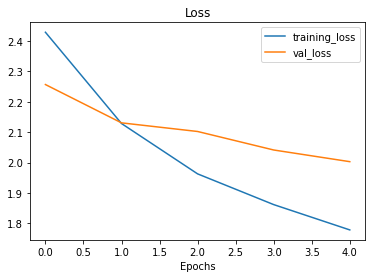

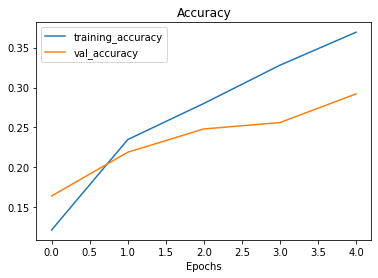

In [12]:
plot_loss_curves(mobilenet_model_history)